## Projet : Analyse et Classification d’Articles de Presse

## Kuassi Pierre DOVODJI - Evencia MICHONDARD

## 1.Prétraitement des données

#### donnée

In [218]:
import os
import re
import time
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from scipy.stats import uniform, randint
from tabulate import tabulate

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MaxAbsScaler, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score 
from sklearn.metrics import precision_score, confusion_matrix, roc_curve, auc


warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(42)

In [127]:
with open("./Articles/article_economie0.txt","r") as f:
    data=f.read()

In [128]:
data

'Nippon Steel et US\xa0Steel attaquent l’administration de Joe Biden pour «\xa0ingérence illégale\xa0»\n\n    Les deux groupes contestent le blocage de l’acquisition à 14,9\xa0milliards de dollars, jugée risquée pour la sécurité nationale par le président américain. \n\nLes aciéristes japonais Nippon Steel et américain US\xa0Steel vont intenter une action en justice contre l’administration de Joe Biden, pour «\xa0ingérence illégale\xa0» dans le projet de rachat d’US\xa0Steel par le sidérurgiste nippon, ont-ils annoncé lundi 6\xa0janvier.\nDans un communiqué commun, les deux groupes ont déclaré avoir déposé un recours devant une cour d’appel américaine pour contester le processus d’examen du rachat d’US\xa0Steel par Nippon Steel, estimant que le président Biden avait usé de son influence de façon indue à des fins politiques. Joe Biden a annoncé vendredi qu’il bloquait cette acquisition à 14,9\xa0milliards de dollars, estimant qu’elle poserait des «\xa0risques\xa0» pour la sécurité natio

In [129]:
# Création du DataFrame pour les articles
data_article = pd.DataFrame({'texte': [], 'type': [], 'titre': [], 'description': []})

titres = []
descriptions = []
textes = []
types = []

# Lecture des articles
for fichier in os.listdir('./Articles/'):
    with open('./Articles/' + fichier, "r", encoding="utf8") as f:
        article = f.read()
    article = article.split("\n\n")
    titres.append(article[0])
    descriptions.append(article[1])
    textes.append(article[2])
    type_article = fichier.split("_")[1].split(".")[0].rstrip("0123456789")  # Extraction propre du type (e.g., economie, sport)
    types.append(type_article)

data_article['titre'] = titres
data_article['description'] = descriptions
data_article['texte'] = textes
data_article['type'] = types

print("Total :", data_article.shape[0], "articles")
data_article.head()

Total : 3681 articles


,texte,type,titre,description
0,Les bonnes résolutions n’ont pas attendu 2025 ...,sport,"« La folie arrive toute seule, pas besoin de l...",Wemby a inscrit 27 points et guidé dès l’entam...
1,Troisième victoire consécutive pour Mathieu Va...,sport,Cyclo-cross de Gavere : les images de l’impres...,La 7e manche de la Coupe du monde de cyclo-cro...
2,"Meilleure arbitre de la planète depuis 2019, l...",sport,Football : Stéphanie Frappart n’est plus la me...,Alors que François Letexier vient d’être désig...
3,C’est l’un des noms dont vous allez entendre p...,sport,Affaire Dani Olmo : 5 minutes pour comprendre ...,Le milieu espagnol n’a pas été inscrit sur les...
4,Une espèce inconnue de lézard a été découverte...,science,Un lézard inconnu découvert au Pérou baptisé e...,"Le spécimen « Enyalioides dickinsoni », de son..."


In [130]:
data_article.head()

,texte,type,titre,description
0,Les bonnes résolutions n’ont pas attendu 2025 ...,sport,"« La folie arrive toute seule, pas besoin de l...",Wemby a inscrit 27 points et guidé dès l’entam...
1,Troisième victoire consécutive pour Mathieu Va...,sport,Cyclo-cross de Gavere : les images de l’impres...,La 7e manche de la Coupe du monde de cyclo-cro...
2,"Meilleure arbitre de la planète depuis 2019, l...",sport,Football : Stéphanie Frappart n’est plus la me...,Alors que François Letexier vient d’être désig...
3,C’est l’un des noms dont vous allez entendre p...,sport,Affaire Dani Olmo : 5 minutes pour comprendre ...,Le milieu espagnol n’a pas été inscrit sur les...
4,Une espèce inconnue de lézard a été découverte...,science,Un lézard inconnu découvert au Pérou baptisé e...,"Le spécimen « Enyalioides dickinsoni », de son..."


In [131]:
article

['Transport\xa0: entre la France et ses voisins, l’Europe pousse au rail',
 'Alors que 80\xa0% des récents investissements européens en matière d’infrastructures de transport sont destinés au ferroviaire, «Libé» fait l’état des lieux des liaisons existantes ou attendues entre la France et ses principaux pays frontaliers. Et sur l’avancement du Réseau transeuropéen de transport.',
 'Porté par une volonté de décarboner les transports – deuxième secteur émetteur de gaz à effet de serre en Europe – et de voyager différemment, le train est enfin repris au sérieux par les pouvoirs publics. Si l’Italie, l’Espagne ou encore l’Allemagne ont annoncé des centaines de milliards d’euros d’investissements en 2024, ce sont tous les pays européens qui avancent. Il faut dire que la Commission européenne, parfois trop timorée sur sa politique industrielle ou les sujets de concurrence, se veut très énergique sur le sujet.\nSon vaisseau amiral est le Réseau transeuropéen de transport (RTE-T). Pensé pour m

## 2.1 Prétraitement des données

Nous allons définie une fonction qui permet de faire la tokenisation des textes. Cette fonction va permettre de nettoyer d'un texte les l'expression régulière, les espace vide inutile et transformer le texte en une liste de mots.

In [132]:
def tokenizer(texte):
    ponct = [',','-',':','!','?','.',';','...','’','(',')','/','..',"'",'«','»','\n']
    texte = texte.replace("  "," ")
    texte = texte.replace("\xa0"," ")
    for i in ponct:
        texte = texte.replace(i,"")
    texte = texte.replace("\ ","")
    texte = texte.lower().split(" ")
    texte = [x for x in texte if x!='']
    return texte

<>:7: SyntaxWarning: invalid escape sequence '\ '
<>:7: SyntaxWarning: invalid escape sequence '\ '
/var/folders/lq/5q38qx610qlffvdlnlwcn2zm0000gn/T/ipykernel_39548/2603097829.py:7: SyntaxWarning: invalid escape sequence '\ '
  texte = texte.replace("\ ","")


In [133]:
from unidecode import unidecode

def tokenizer(texte):
    texte = re.sub(r'\s+', ' ', texte)
    texte = re.sub(r'\\', ' ', texte)
    texte = re.sub(r'\xa0', ' ', texte)
    texte = re.sub(r'[.,:!?;…’()/«»\n]', '', texte)
    texte = unidecode(texte)
    tokens = texte.lower().split()
    return tokens



In [134]:
text = "Bonjour, je suis un t il texte\  de test. Je sûis un texte de test, bonjour."
tokenizer(text)

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/var/folders/lq/5q38qx610qlffvdlnlwcn2zm0000gn/T/ipykernel_39548/2588606301.py:1: SyntaxWarning: invalid escape sequence '\ '
  text = "Bonjour, je suis un t il texte\  de test. Je sûis un texte de test, bonjour."


['bonjour',
 'je',
 'suis',
 'un',
 't',
 'il',
 'texte',
 'de',
 'test',
 'je',
 'suis',
 'un',
 'texte',
 'de',
 'test',
 'bonjour']

In [135]:
def nb_mots(texte):
    return len(tokenizer(texte))

Suppression des stopwords et des mots de moins de 3 lettres

In [136]:
# Stopwords
stop_words_fr = stopwords.words('french')
try:
	with open("stopword.txt", encoding='utf-8') as f:
		stop_words_custom = [w.strip() for w in f.read().split(",")]
except FileNotFoundError:
	print("Fichier stopword.txt non trouvé. Utilisation des stopwords par défaut.")
	stop_words_custom = []

stop_words = set(stop_words_fr + stop_words_custom)
stop_words.update({'faire', 'encore', 'trois','apres', 'faire', 'quelques','alors','dautres', 'dautre' 'avoir', 'etait'})

In [137]:
# Application du prétraitement
def retirer_stopwords(texte):
    texte = [i for i in texte if len(i) > 4 and i not in stop_words]  
    return texte

In [138]:
data_article['tokens'] = data_article['texte'].apply(tokenizer)
data_article['tokens_sans_stopwords'] = data_article['tokens'].apply(retirer_stopwords)

In [139]:
# Exploration des données
print("\nAnalyse exploratoire :")
data_article['longueur'] = data_article['tokens_sans_stopwords'].apply(len)
print("Longueur moyenne des articles par catégorie :")
print(data_article.groupby('type')['longueur'].mean())


Analyse exploratoire :
Longueur moyenne des articles par catégorie :
type
economie    183.500000
science     186.386081
sport       196.638498
Name: longueur, dtype: float64


In [140]:
from collections import Counter

freq_par_categorie = {}

# Extraitraction les mots fréquents pour chaque catégorie
for categorie in data_article['type'].unique():
    tous_les_mots = [mot for tokens in data_article[data_article['type'] == categorie]['tokens_sans_stopwords'] for mot in tokens]
    mots_frequents = Counter(tous_les_mots).most_common(10)
    freq_par_categorie[categorie] = mots_frequents
df_freq = pd.DataFrame(freq_par_categorie)
df_freq.index = range(1, 11)
pd.set_option('display.max_rows', None) # Afficher toutes les lignes
print(df_freq.head(10))

                sport               science             economie
1      (france, 1435)          (terre, 758)       (france, 1149)
2       (paris, 1144)        (mission, 610)  (gouvernement, 923)
3       (monde, 1018)       (spatiale, 569)        (deuros, 799)
4       (finale, 925)       (premiere, 541)      (millions, 737)
5    (olympique, 841)         (france, 508)      (ministre, 710)
6        (match, 785)  (scientifiques, 496)         (euros, 648)
7     (francais, 715)        (premier, 466)      (decembre, 636)
8        (place, 674)     (chercheurs, 452)        (groupe, 611)
9   (olympiques, 634)         (annees, 437)     (milliards, 588)
10     (premier, 619)          (monde, 425)        (budget, 554)


In [141]:
data_article['nb_mots'] = data_article['tokens'].apply(len)

In [142]:
# avec les stopword
print("Longueur moyenne des articles par catégorie :")
print(data_article.groupby('type')['nb_mots'].mean())

Longueur moyenne des articles par catégorie :
type
economie    414.816054
science     417.575808
sport       449.822379
Name: nb_mots, dtype: float64


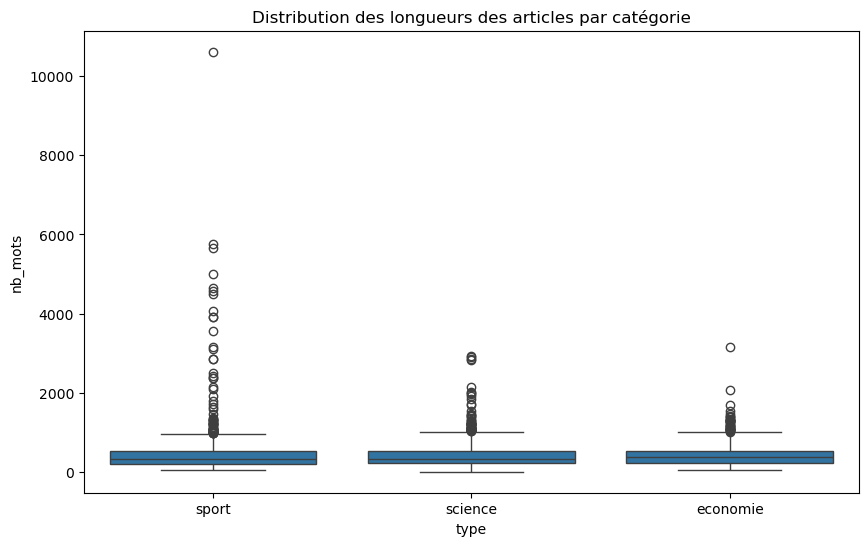

In [143]:
# Visualisation des distributions de longueur des articles
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='nb_mots', data=data_article)
plt.title('Distribution des longueurs des articles par catégorie')
plt.show()

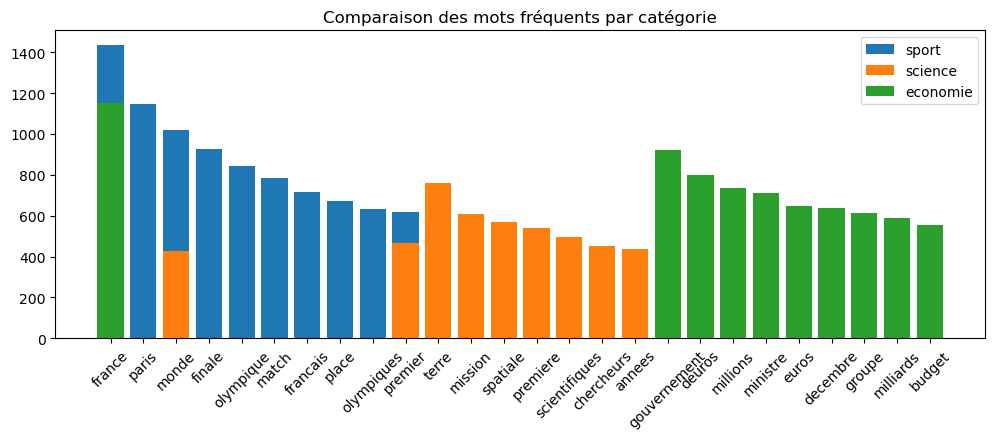

In [144]:
# Visualisation du champ lexical
plt.figure(figsize=(12, 4))
for categorie, mots in freq_par_categorie.items():
    mots_, frequences = zip(*mots)
    plt.bar(mots_, frequences, label=categorie)
plt.title("Comparaison des mots fréquents par catégorie")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Regardons le nombre de mot unique par catégorie

In [145]:
# Compter les mots distincts par catégorie
print("Nombre de mots distincts par catégorie :")
distinct_words_per_category = data_article.groupby('type')['tokens_sans_stopwords'].apply(lambda x: set([word for tokens in x for word in tokens])).apply(len)
print(distinct_words_per_category)


Nombre de mots distincts par catégorie :
type
economie    29196
science     35618
sport       37711
Name: tokens_sans_stopwords, dtype: int64


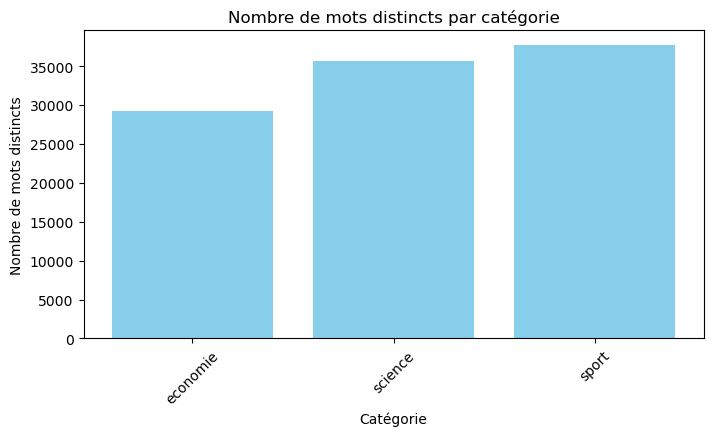

In [146]:
plt.figure(figsize=(8, 4))

plt.bar(distinct_words_per_category.index,distinct_words_per_category.values, color='skyblue')
plt.title("Nombre de mots distincts par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de mots distincts")
plt.xticks(rotation=45)

# Affichage du graphique
plt.show()

In [147]:
print('Nombre de mots distincts par catégorie :')
distinct_words_per_category

Nombre de mots distincts par catégorie :


type
economie    29196
science     35618
sport       37711
Name: tokens_sans_stopwords, dtype: int64

In [148]:
vectorizer = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 2))

top_tfidf_words_par_cat = {}

for categorie in data_article['type'].unique():
    data_categorie = data_article[data_article['type'] == categorie]
    X_tfidf = vectorizer.fit_transform(data_categorie['tokens_sans_stopwords'].apply(lambda x: ' '.join(x)))
    
    tfidf_scores = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    top_tfidf_words = tfidf_scores.mean().sort_values(ascending=False).head(10)
    top_tfidf_words_par_cat[categorie] = [(mot, freq) for mot, freq in zip(top_tfidf_words.index, top_tfidf_words)]
top_tfidf_df = pd.DataFrame(top_tfidf_words_par_cat)

# Affichage du DataFrame avec les tuples
print("Top 10 des mots les plus caractéristiques par catégorie avec leurs fréquences sous forme de tuple :")
top_tfidf_df

Top 10 des mots les plus caractéristiques par catégorie avec leurs fréquences sous forme de tuple :


,sport,science,economie
0,"(france, 0.014075993644333594)","(terre, 0.010349683459011116)","(france, 0.014092346165603542)"
1,"(paris, 0.012633548105872963)","(mission, 0.00976435029620973)","(gouvernement, 0.012766511797563856)"
2,"(monde, 0.01094651711704772)","(spatiale, 0.009163989475684496)","(ministre, 0.010693049147550435)"
3,"(finale, 0.010561236408139073)","(france, 0.008060868471957132)","(deuros, 0.01065963944685863)"
4,"(match, 0.010047010107883904)","(fusee, 0.007737894656417705)","(euros, 0.01034720390435443)"
5,"(francais, 0.009653496635244646)","(premiere, 0.007714572519211696)","(budget, 0.0103052353010635)"
6,"(paralympiques, 0.008972215525097702)","(lespace, 0.007301982815499585)","(millions, 0.00979383946471705)"
7,"(olympique, 0.008941869274613611)","(scientifiques, 0.0069983253707187765)","(decembre, 0.009535500131594928)"
8,"(olympiques, 0.00806695074563789)","(premier, 0.0065576965051356104)","(milliards, 0.009162453787493917)"
9,"(vendredi, 0.007728166964363075)","(spacex, 0.006552417713835099)","(groupe, 0.00888146951681044)"


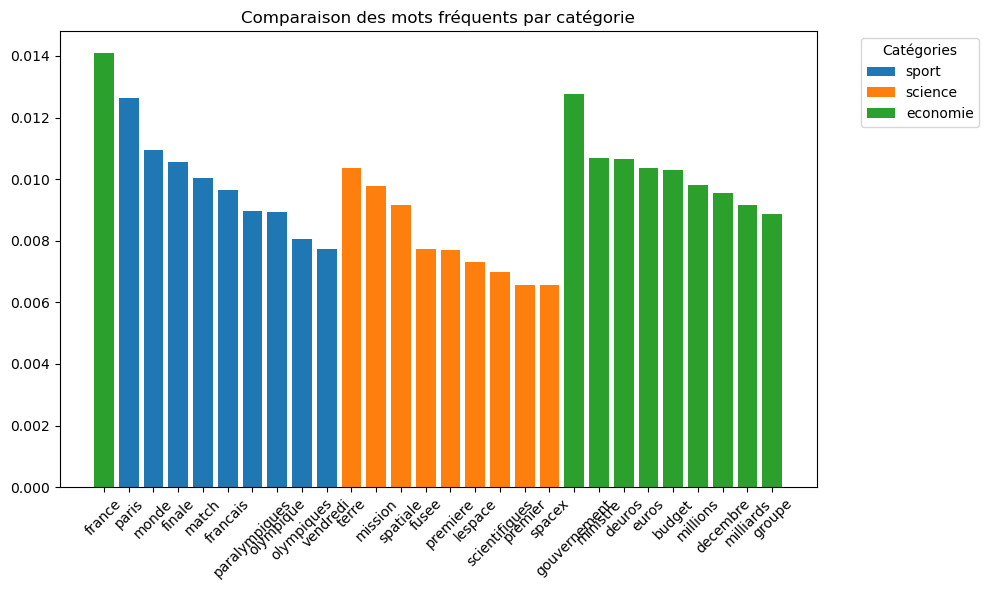

In [149]:

plt.figure(figsize=(10, 6))
for categorie, mots in top_tfidf_words_par_cat.items():
    mots_, frequences = zip(*mots)
    plt.bar(mots_, frequences, label=categorie) 
plt.title("Comparaison des mots fréquents par catégorie")
plt.legend(title='Catégories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  
plt.tight_layout()  # Ajuste le layout pour éviter le chevauchement des éléments
plt.show()

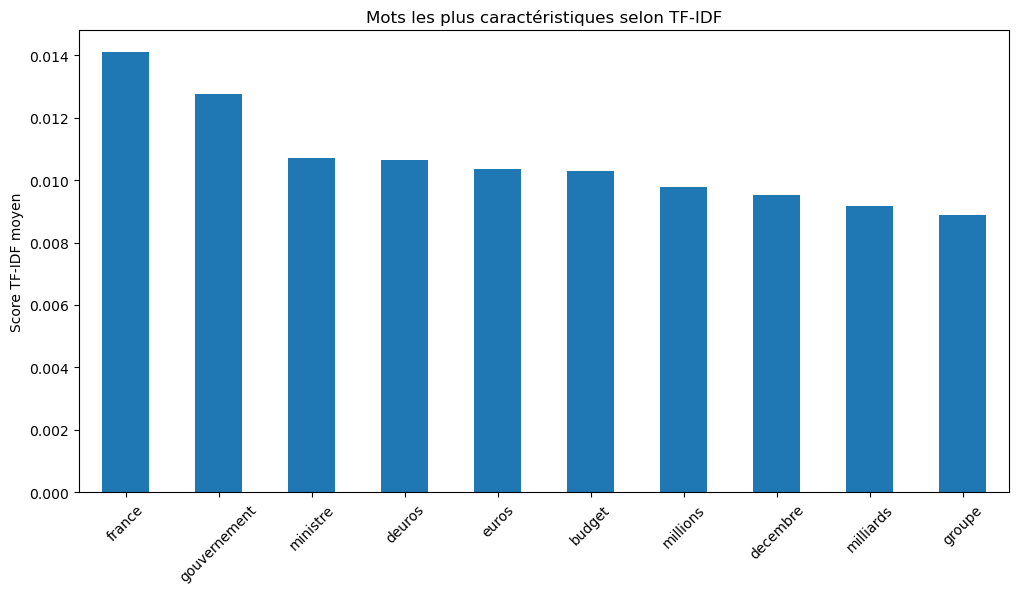

In [150]:
# Visualisation des mots caractéristiques
plt.figure(figsize=(12, 6))
top_tfidf_words.plot(kind='bar')
plt.title("Mots les plus caractéristiques selon TF-IDF")
plt.ylabel("Score TF-IDF moyen")
plt.xticks(rotation=45)
plt.show()


In [151]:
all_sport = []
all_economie = []
all_science = []
for u in list(data_article[data_article['type']=='sport']['tokens_sans_stopwords']):
    all_sport += u

for u in list(data_article[data_article['type']=='economie']['tokens_sans_stopwords']):
    all_economie += u      
for u in list(data_article[data_article['type']=='science']['tokens_sans_stopwords']):
    all_science += u

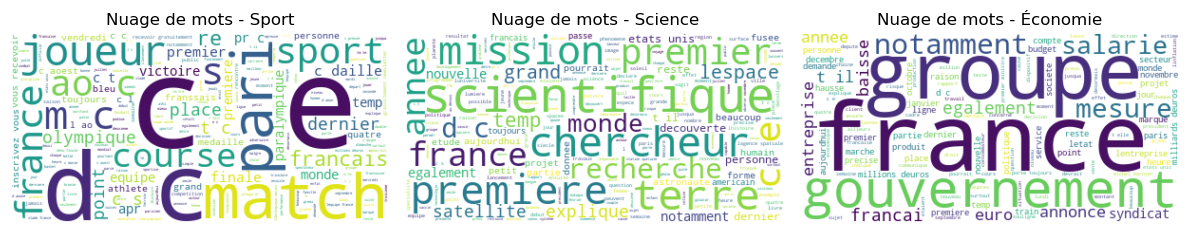

In [152]:

from wordcloud import WordCloud

wordcloud_sport = WordCloud(background_color="white").generate(' '.join(all_sport))
wordcloud_science = WordCloud(background_color="white").generate(' '.join(all_science))
wordcloud_economie = WordCloud(background_color="white").generate(' '.join(all_economie))

plt.figure(figsize=(12, 6))


plt.subplot(1, 3, 1) 
plt.imshow(wordcloud_sport, interpolation="bilinear")
plt.title("Nuage de mots - Sport")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_science, interpolation="bilinear")
plt.title("Nuage de mots - Science")
plt.axis("off")


plt.subplot(1, 3, 3) 
plt.imshow(wordcloud_economie, interpolation="bilinear")
plt.title("Nuage de mots - Économie")
plt.axis("off")

plt.tight_layout()
plt.show()


## Classification de thématique article
C1 : Utilisation du titre<br>
C2 : Utilisation du titre et de la description<br>
C3 : Utilisation du titre, description et contenu complet<br>


In [153]:
data_article['C1'] = data_article['titre']
data_article['C2'] = data_article['titre'] + " " + data_article['description']
data_article['C3'] = data_article['titre'] + " " + data_article['description'] + " " + data_article['texte']

In [154]:
label_names = ['science ','economie', 'sport']
data_article['label'] = data_article['type'].apply(lambda x: 1 if x == 'economie' else 2 if x == 'sport' else 0)

Nous allons creer des fonctions pour automatise nos taches.

- métric() pour calculer les métriques
- print_score() : pour afficher les scores des modèles sous forme de tableau
- print_resultats() : pour affichage de la matrice de confusion et des courbes ROC multiclasses côte à côte.
- plot_prediction_probabilities(): pour comparer les probabilités de prédiction entre les observations correctement classées et celles mal classées pour un modèle donné.

In [155]:
# Fonction pour calculer les métriques
def metric(y_true, y_pred):
    """
    Calcule plusieurs métriques d'évaluation pour un modèle de classification.

    Args:
        y_true : Les valeurs réelles des classes.
        y_pred : Les prédictions faites par le modèle.

    Returns:
        list: Un tableau contenant les métriques suivantes :
            - Accuracy
            - F1-score 
            - Precision 
            - Recall 
    """
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return [accuracy, f1, precision, recall]

name_score = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

# Fonction pour afficher les scores des modèles sous forme de tableau
def print_score(scores_train=None, scores_test=None, times=None):
    """
    Affiche les scores des modèles sous forme de tableau.

    Args:
        scores: Dictionnaire contenant les scores de chaque modèle.
    """
    pd.set_option('display.max_rows', 8)
    if scores_train != None :
        print("-----------------------------------Train----------------------------------")
        scores_df = pd.DataFrame.from_dict(scores_train, orient='index', columns=name_score)
        print(tabulate(scores_df, headers="keys", tablefmt="github"))
    
    if scores_test != None :
        print("\n-----------------------------------Test----------------------------------")
        scores_df1 = pd.DataFrame.from_dict(scores_test, orient='index', columns=name_score)
        print(tabulate(scores_df1, headers="keys", tablefmt="github"))

    if times != None :
        print("\n-------Temps d'inférence-----------")
        df = pd.DataFrame.from_dict(times, orient='index')
        print(tabulate(df.head(8), tablefmt="github"))


In [214]:

def plot_prediction_probabilities(model, X_test, y_test):
    """
    Cette fonction permet de comparer les probabilités de prédiction entre les observations correctement 
    classées et celles mal classées pour un modèle donné.

    Paramètres :
    - model : Le modèle de classification entraîné (par exemple, régression logistique, SVM, etc.)
    - X_test : Les données de test 
    - y_test : Les vraies étiquettes 

    Résultat :
    Affiche un graphique montrant la répartition des probabilités maximales pour les classes correctement et incorrectement classées.
    """
    
    probabilities = model.predict_proba(X_test)
    predicted_labels = np.argmax(probabilities, axis=1)

    correct = (predicted_labels == y_test.values) 
    incorrect = (predicted_labels != y_test.values) 
    correct_probs = np.max(probabilities[correct], axis=1)
    incorrect_probs = np.max(probabilities[incorrect], axis=1)

    plt.figure(figsize=(10, 6))
    sns.histplot(correct_probs, bins=20, alpha=0.7, label='Correctement classées', kde=True, stat="density")
    sns.histplot(incorrect_probs, bins=20, alpha=0.7, label='Incorrectement classées', kde=True, stat="density")
    plt.legend(loc='upper right')
    plt.xlabel('Probabilité maximale')
    plt.ylabel('Fréquence')
    plt.title('Répartition des probabilités de prédiction pour les classes')
    plt.show()

In [156]:
def print_resultats(X_test, y_test, model):
    """
    Affichage de la matrice de confusion et des courbes ROC multiclasses côte à côte.

    Args:
        X_test : Ensemble de test.
        y_test : Labels réels.
        model : Modèle entraîné.
    """
    y_pred = model.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))


    cm = confusion_matrix(y_test, y_pred)
    classes = sorted(set(y_test)) 

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_title('Matrice de Confusion')
    axes[0].set_xlabel('Prédictions')
    axes[0].set_ylabel('Véritables classes')
    

    y_test_bin = label_binarize(y_test, classes=classes)
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(y_test_bin.shape[1]):
        axes[1].plot(fpr[i], tpr[i], lw=2, label=f'Classe {classes[i]} (AUC = {roc_auc[i]:.2f})')

    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Taux de Faux Positifs')
    axes[1].set_ylabel('Taux de Vrais Positifs')
    axes[1].set_title('Courbes ROC Multiclasses')
    axes[1].legend(loc="lower right")
    plt.tight_layout()
    plt.show()


In [157]:
def evaluer_modele(X_train, X_test, y_train, y_test, models, param_distributions, vectoriseur=TfidfVectorizer(stop_words =list(stop_words), ngram_range=(1,2))):
    
    scores_train = {}
    scores_test = {}
    inference_times = {}
    best_models = {} 

    for model_name, model_obj in models.items():
        pipe = Pipeline(steps=[
            ('vectorizer', vectoriseur),
            ('scaler', MaxAbsScaler()), 
            ('regressor', model_obj)
        ])
        
       
        random_search = RandomizedSearchCV(pipe, param_distributions=param_distributions[model_name], 
                                           n_iter=10, cv=5, random_state=42, n_jobs=-1)
        random_search.fit(X_train, y_train)
        mod = random_search.best_estimator_.fit(X_train, y_train)
        
        best_models[model_name] = mod
        
        start_time = time.time()
        y_pred = mod.predict(X_test)
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times[model_name] = inference_time
        
        y_train_pred = mod.predict(X_train)
        scores_train[model_name] = metric(y_train, y_train_pred)
        scores_test[model_name] = metric(y_test, y_pred)
        
    return best_models, scores_train, scores_test, inference_times

In [158]:
# Dictionnaire des modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42,n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "xGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "MultinomialNB": MultinomialNB() 
}

# Paramètres de recherche pour RandomizedSearchCV
param_distributions = {
    "Logistic Regression": {
        'regressor__C': np.linspace(0.01, 10, num=20)  
    },
    "Decision Tree": {
        'regressor__max_depth': np.linspace(1, 20, num=20, dtype=int),
        'regressor__min_samples_split': np.linspace(2, 20, num=10, dtype=int),
        'regressor__min_samples_leaf': np.linspace(1, 20, num=10, dtype=int)
    },
    "Random Forest": {
        'regressor__n_estimators': np.array([100, 200, 300, 500]),
        'regressor__max_depth': np.linspace(1, 20, num=10, dtype=int),
        'regressor__min_samples_split': np.linspace(2, 20, num=10, dtype=int),
        'regressor__min_samples_leaf': np.linspace(1, 20, num=10, dtype=int),
        'regressor__bootstrap': [True, False]
    },
    "Gradient Boosting": {
        'regressor__n_estimators': np.array([100, 200, 300, 500]),
        'regressor__learning_rate': np.linspace(0.01, 0.1, num=10),
        'regressor__max_depth': np.linspace(1, 10, num=10, dtype=int),
        'regressor__min_samples_split': np.linspace(2, 20, num=10, dtype=int)
        
    },
    "xGBoost": {
        'regressor__n_estimators': np.array([100, 200, 300, 500]),
        'regressor__learning_rate': np.linspace(0.01, 0.1, num=10),
        'regressor__max_depth': np.linspace(1, 10, num=10, dtype=int),
        'regressor__min_child_weight': np.linspace(1, 10, num=10, dtype=int),
        'regressor__reg_alpha': np.linspace(0, 1, num=10),
        'regressor__reg_lambda': np.linspace(0, 1, num=10)
    },
    "KNN": {
        'regressor__n_neighbors': np.linspace(3, 20, num=10, dtype=int),
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1, 2]
    },
    "SVM": {  
        'regressor__C': np.linspace(0.01, 10, num=20),
        'regressor__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'regressor__gamma': ['scale', 'auto']
    },
    "MultinomialNB": {  
        'regressor__alpha': np.linspace(0.01, 2, num=10),
        'regressor__fit_prior': [True, False] 
    }
}


In [159]:
X_train, X_test, y_train, y_test = train_test_split(data_article[['C1','C2','C3']], data_article['label'], test_size=0.3, random_state=42)


In [160]:
# Transformer les données textuelles en vecteurs TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(stop_words))

In [161]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2576, 3), (2576,), (1105, 3), (1105,))

In [162]:
data_article['type'].value_counts()/data_article.shape[0]

type
sport       0.347188
science     0.327900
economie    0.324912
Name: count, dtype: float64

In [163]:
y_train.value_counts()/y_train.shape[0]

label
2    0.352096
0    0.329581
1    0.318323
Name: count, dtype: float64

In [164]:
y_test.value_counts()/y_test.shape[0]

label
1    0.340271
2    0.335747
0    0.323982
Name: count, dtype: float64

Nous avons plutot une bonne répartion des classes dans la base de données et aussi dans l'ensembles test et l'ensemble d'entrainement. 

### Modeèle avec C1

In [165]:
vectorizer = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,2)) 
X_train_C1 = vectorizer.fit_transform(X_train['C1'])
X_train_C1.shape

(2576, 23981)

In [166]:

model_C1, score_train_C1, score_test_C1, times_C1 = evaluer_modele(X_train['C1'],
                                                X_test['C1'], 
                                                y_train, 
                                                y_test, 
                                                models, 
                                                param_distributions)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

#### Affichage des métriques

In [167]:

print_score(score_train_C1, score_test_C1, times_C1)

-----------------------------------Train----------------------------------
|                     |   Accuracy |   F1 Score |   Precision |   Recall |
|---------------------|------------|------------|-------------|----------|
| Logistic Regression |   0.97205  |   0.97209  |    0.972531 | 0.97205  |
| Decision Tree       |   0.612966 |   0.581825 |    0.780551 | 0.612966 |
| Random Forest       |   0.854814 |   0.856247 |    0.88217  | 0.854814 |
| Gradient Boosting   |   0.971661 |   0.971659 |    0.971891 | 0.971661 |
| xGBoost             |   0.783385 |   0.7853   |    0.837958 | 0.783385 |
| KNN                 |   0.97205  |   0.97207  |    0.972353 | 0.97205  |
| SVM                 |   0.97205  |   0.97208  |    0.97243  | 0.97205  |
| MultinomialNB       |   0.971273 |   0.971274 |    0.971773 | 0.971273 |

-----------------------------------Test----------------------------------
|                     |   Accuracy |   F1 Score |   Precision |   Recall |
|---------------------|--

On constate que le meilleurs est modèle est la regression logistique.

##### Analyse de la performance du meilleur modèle

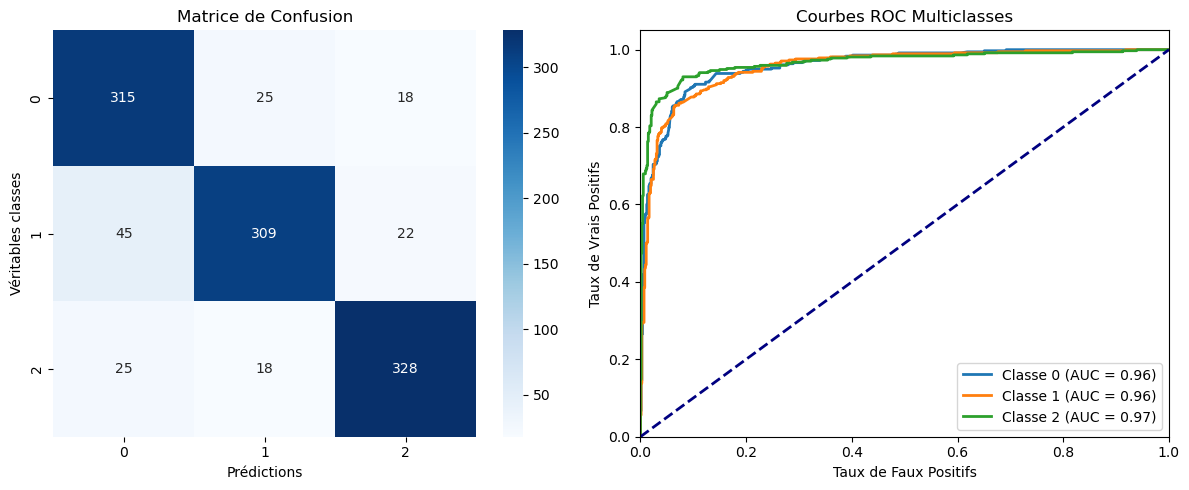

In [180]:
print_resultats(X_test=X_test['C1'], y_test=y_test, model=model_C1['Logistic Regression'])

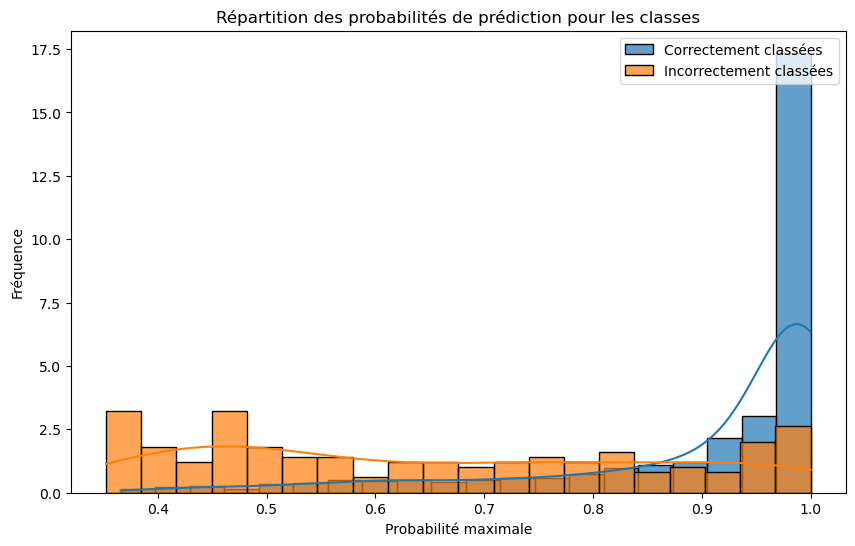

In [208]:
plot_prediction_probabilities(model_C1['Logistic Regression'], X_test['C1'], y_test)

### Modèle C2

In [169]:
vectorizer = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,2)) 
X_train_C2 = vectorizer.fit_transform(X_train['C2'])
X_train_C2.shape

(2576, 71310)

In [170]:
vec = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,2), 
                             max_df=0.95, min_df=0.002, max_features=20000)
X_train_C2 = vec.fit_transform(X_train['C2'])
X_train_C2.shape

(2576, 2878)

In [171]:

model_C2, score_train_C2, score_test_C2, times_C2 = evaluer_modele(X_train['C2'],
                                                X_test['C2'], 
                                                y_train, 
                                                y_test, 
                                                models, 
                                                param_distributions, 
                                                vectoriseur=vec)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:39:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:39:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:39:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:39:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

#### Affichage des métriques

In [172]:
print_score(score_train_C2, score_test_C2, times_C2)

-----------------------------------Train----------------------------------
|                     |   Accuracy |   F1 Score |   Precision |   Recall |
|---------------------|------------|------------|-------------|----------|
| Logistic Regression |   0.968556 |   0.968584 |    0.968877 | 0.968556 |
| Decision Tree       |   0.710792 |   0.704629 |    0.804351 | 0.710792 |
| Random Forest       |   0.911102 |   0.912409 |    0.925555 | 0.911102 |
| Gradient Boosting   |   0.97205  |   0.972087 |    0.972479 | 0.97205  |
| xGBoost             |   0.903727 |   0.904349 |    0.90963  | 0.903727 |
| KNN                 |   0.971273 |   0.971274 |    0.972005 | 0.971273 |
| SVM                 |   0.97205  |   0.972083 |    0.97243  | 0.97205  |
| MultinomialNB       |   0.938665 |   0.938773 |    0.939633 | 0.938665 |

-----------------------------------Test----------------------------------
|                     |   Accuracy |   F1 Score |   Precision |   Recall |
|---------------------|--

On constate que le meilleurs est modèle est la regression logistique.

##### Analyse de la performance du meilleur modèle

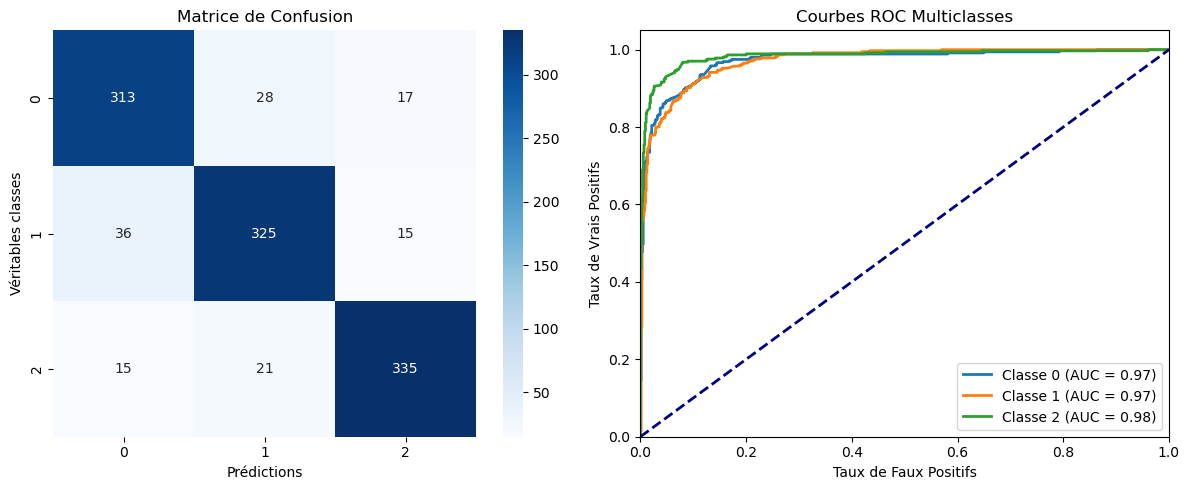

In [181]:
print_resultats(X_test['C2'], y_test, model_C2['Logistic Regression'])

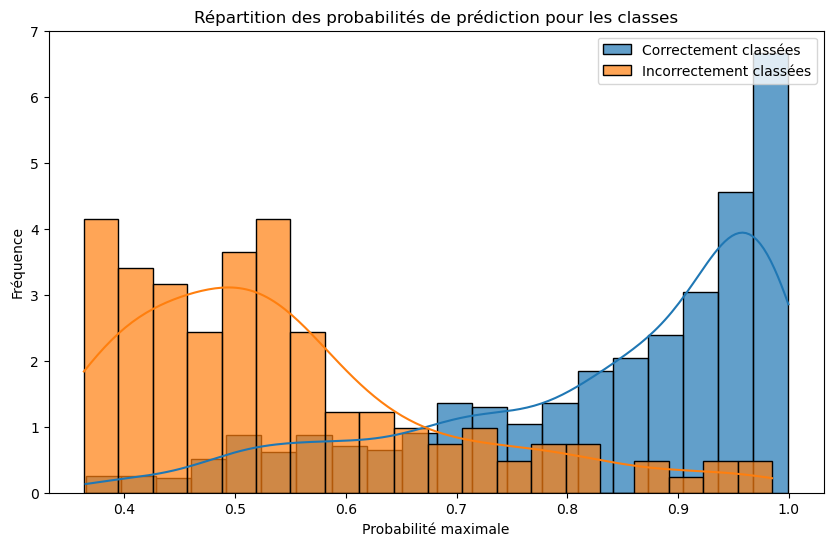

In [217]:
plot_prediction_probabilities(model_C2['Logistic Regression'], X_test['C2'], y_test)

## Modèle avec C3

In [174]:
vectorizer = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,2)) 
X_train_C3 = vectorizer.fit_transform(X_train['C3'])
X_test_C3 = vectorizer.fit_transform(X_test['C3'])
X_train_C3.shape

(2576, 540339)

In [191]:
vec3 = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1,2), 
                             max_df=0.95, min_df=0.002, max_features=20000)
X_train_C3 = vec3.fit_transform(X_train['C3'])
X_train_C3.shape

(2576, 17531)

In [176]:

param = {
    "Logistic Regression": {
        'regressor__C': np.linspace(0.01, 5, num=10) 
    },
    "Decision Tree": {
        'regressor__max_depth': np.arange(3, 16, 2),  
        'regressor__min_samples_split': np.arange(5, 16, 2),  
        #'regressor__min_samples_leaf': np.arange(2, 11, 2)
    },
    "Random Forest": {
        'regressor__n_estimators': np.array([50, 500, 10]),
        'regressor__max_depth': np.arange(3, 11, 2),
        #'regressor__min_samples_split': np.arange(5, 16, 2),
        #'regressor__min_samples_leaf': np.arange(2, 11, 2),
        #'regressor__bootstrap': [True, False]
    },
    "Gradient Boosting": {
        'regressor__n_estimators':np.array([50, 500, 10]),
        'regressor__learning_rate': np.linspace(0.01, 0.1, num=10), 
        #'regressor__max_depth': np.arange(3, 9, 2),
        #'regressor__min_samples_split': np.arange(5, 16, 2)
    },
    "xGBoost": {
        'regressor__n_estimators':np.array([50, 500, 10]),
        'regressor__learning_rate': np.linspace(0.01, 0.1, num=10),
        #'regressor__max_depth': np.arange(3, 9, 2),
    },
    "KNN": {
        'regressor__n_neighbors': np.arange(3, 16, 2)
        
    },
    "SVM": {  
        'regressor__C': np.linspace(0.01, 5, num=5),
        'regressor__kernel': ['linear', 'rbf'],
        #'regressor__gamma': ['scale']
    },
    "MultinomialNB": {  
        'regressor__alpha': np.linspace(0.01, 1, num=10),
        #'regressor__fit_prior': [True, False]
    }
}

In [192]:
model_C3, score_train_C3, score_test_C3, times_C3 = evaluer_modele(X_train['C3'],
                                                X_test['C3'], 
                                                y_train, 
                                                y_test, 
                                                models, 
                                                param_distributions=param, 
                                                vectoriseur=vec3)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:59:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

#### Affichage des métriques

##### Analyse de la performance du meilleur modèle

In [194]:
print_score(score_train_C3, score_test_C3, times_C3)

-----------------------------------Train----------------------------------
|                     |   Accuracy |   F1 Score |   Precision |   Recall |
|---------------------|------------|------------|-------------|----------|
| Logistic Regression |   0.97205  |   0.972091 |    0.972582 | 0.97205  |
| Decision Tree       |   0.889752 |   0.890586 |    0.898331 | 0.889752 |
| Random Forest       |   0.947593 |   0.947738 |    0.949092 | 0.947593 |
| Gradient Boosting   |   0.97205  |   0.972084 |    0.972477 | 0.97205  |
| xGBoost             |   0.97205  |   0.972084 |    0.972528 | 0.97205  |
| KNN                 |   0.852484 |   0.845592 |    0.886303 | 0.852484 |
| SVM                 |   0.97205  |   0.972091 |    0.972582 | 0.97205  |
| MultinomialNB       |   0.951475 |   0.951529 |    0.952506 | 0.951475 |

-----------------------------------Test----------------------------------
|                     |   Accuracy |   F1 Score |   Precision |   Recall |
|---------------------|--

On constate que le meilleurs est modèle est la regression logistique.

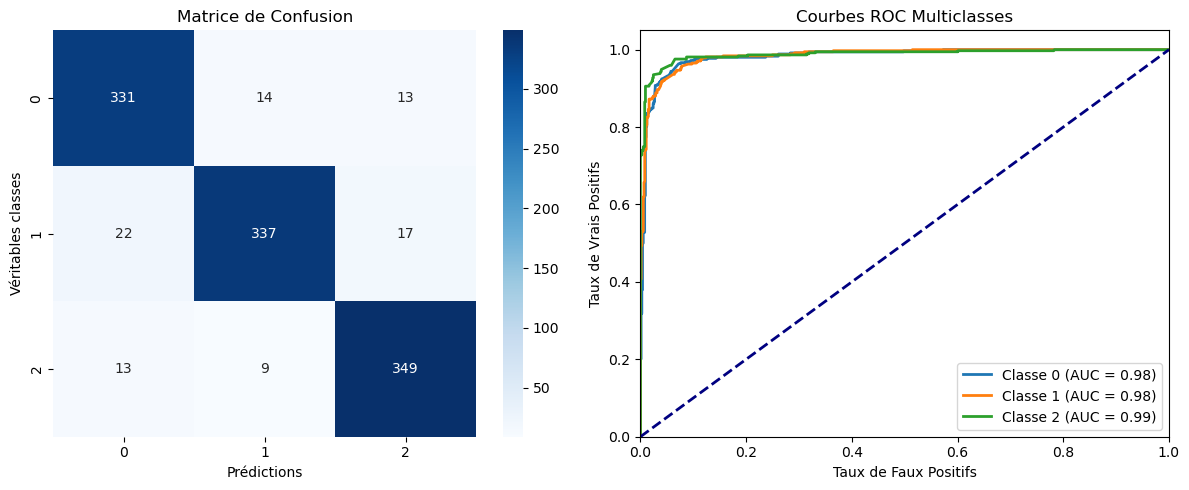

In [213]:
print_resultats(X_test['C3'], y_test, model_C3['Logistic Regression'])

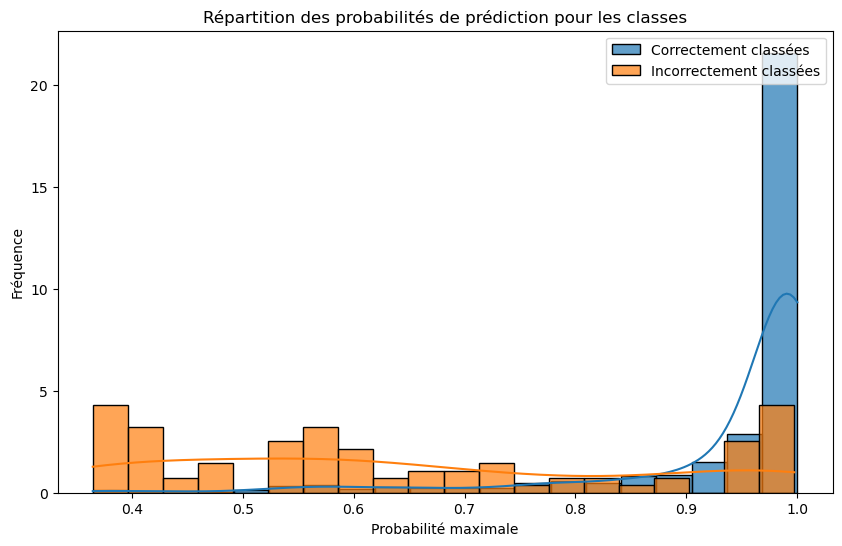

In [216]:
plot_prediction_probabilities(model_C3['Logistic Regression'], X_test['C3'], y_test)

 Tester le modèle final  qui le model de regression logistique du sénario 2 sur un nouveux article généré avec l'IA.

In [226]:
science = {
    "Titre": ["Les Mystères de l’Eau sur Mars"],
    "Description": ["Depuis plusieurs années, les scientifiques tentent de comprendre la présence passée et actuelle de l’eau sur Mars. Grâce aux récentes missions spatiales, des indices suggèrent que la planète rouge a possédé des océans et des rivières, soulevant des questions sur une possible vie martienne."],
    "Texte": [
        """La recherche d’eau sur Mars est l’un des axes majeurs de l’exploration spatiale. Les observations des sondes spatiales et des rovers, comme Curiosity et Perseverance, ont révélé des formations géologiques évoquant des lits de rivières asséchées et des minéraux hydratés, preuve que l’eau a coulé à la surface il y a des milliards d’années.

        Plus récemment, des chercheurs ont identifié des réserves de glace souterraine et des signes potentiels de saumures liquides dans certaines régions martiennes. Ces découvertes renforcent l’hypothèse selon laquelle Mars aurait pu abriter des formes de vie microbiennes dans le passé, et peut-être encore aujourd’hui sous sa surface.

        L’étude de l’eau martienne ne se limite pas à la recherche de vie. Elle joue un rôle clé dans la préparation des futures missions habitées. La présence de glace pourrait être exploitée pour produire de l’eau potable et du carburant, facilitant ainsi une éventuelle colonisation humaine.

        Les prochaines missions, notamment le programme Mars Sample Return de la NASA et de l’ESA, permettront d’analyser des échantillons martiens avec des instruments avancés sur Terre, apportant des réponses essentielles sur l’histoire climatique et géologique de la planète rouge.

        Mars continue donc de fasciner les scientifiques du monde entier, et chaque nouvelle découverte nous rapproche un peu plus de la compréhension de notre place dans l’univers."""
    ]
}

new_article = pd.DataFrame(science)
df = pd.DataFrame(new_article['Titre'] + " " + new_article['Description'])
pred = model_C3['Logistic Regression'].predict(df[0])
prob = model_C3['Logistic Regression'].predict_proba(df[0])
print("Prédiction :", label_names[pred[0]])
print("Probabilités :", prob)

Prédiction : science 
Probabilités : [[0.99635456 0.00182866 0.00181679]]
